<a href="https://colab.research.google.com/github/A-Istrate/80629_Project/blob/main/ML_TPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:
import numpy as np
import pandas as pd
import math
import copy
from random import seed
from random import random
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import os
import re
import gc
import sklearn
from tensorflow.keras import layers
from sklearn.utils import class_weight

Checking our images

In [181]:
gc.collect()

16

In [182]:
## images path
path_s = r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers2"
path = pathlib.Path(path_s)
image_count=len(list(path.glob('*/*.jpg')))
print(image_count)

43325


Checking a childrens book

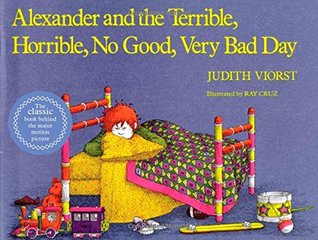

In [183]:
children = list(path.glob('Childrens/*'))
PIL.Image.open(str(children[12]))

Creating a dataset

In [184]:
batch_size =32
img_height = 150
img_width =100
list_ds = tf.data.Dataset.list_files(str(path_s+"\*/*.jp*"),shuffle=False)
list_ds = list_ds.shuffle(image_count,reshuffle_each_iteration=False)

In [185]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Young Adult\\41943.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Mystery & Crime\\29186.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Romance\\14395.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Romance\\39557.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Young Adult\\6322.jpg'


In [186]:
class_names = np.array(sorted([item.name for item in path.glob('*') if os.path.isdir(item)]))
print(class_names)

['Biography' 'Childrens' 'Fantasy' 'Historical' 'Horror' 'Mystery & Crime'
 'Poetry' 'Politics & History' 'Religion & Philosophy' 'Romance'
 'Science Fiction' 'Sequential Art' 'Young Adult']


In [187]:
val_size = int(image_count*0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)


In [188]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

34660
8665


In [189]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  
  return tf.argmax(one_hot)

In [190]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [191]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
         
    return img,label


In [192]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


Image shape:  (150, 100, 3)
Label:  1


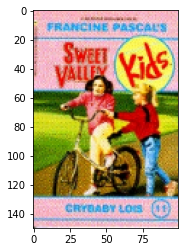

In [193]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  plt.imshow(image.numpy().astype("uint8"))

Image augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom((-0.2,0.2))
])


In [35]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20,horizontal_flip=True,vertical_flip=True,zoom_range=0.2,validation_split=0.2)

In [37]:
img_gen_loaded = img_gen.flow_from_directory(path,target_size=(100,150),batch_size=32)

Found 43390 images belonging to 13 classes.


In [42]:
images = tf.keras.preprocessing.image_dataset_from_directory(path,image_size=(100,150),shuffle=True)

Found 43390 files belonging to 13 classes.


In [91]:
from PIL import Image
def create_dataset_PIL(img_folder):
    
    img_data_array=[]
    class_name=[]
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            ext = os.path.splitext(file)[-1].lower()
            if ext == ".jpg":
                image_path= os.path.join(img_folder, dir1,  file)
                image= np.array(Image.open(image_path))
                image= np.resize(image,(150,100,3))
                image = image.astype('float32')
                image /= 255  
                img_data_array.append(image)
                class_name.append(dir1)
    return img_data_array , class_name

PIL_img_data,img_class_names=create_dataset_PIL(path)

In [94]:
X = np.array(PIL_img_data, np.float32)

In [97]:
bgen = BalancedDataGenerator(X, class_name, img_gen, batch_size=32)
steps_per_epoch = bgen.steps_per_epoch

In [194]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000,reshuffle_each_iteration=False)
  #print(ds)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

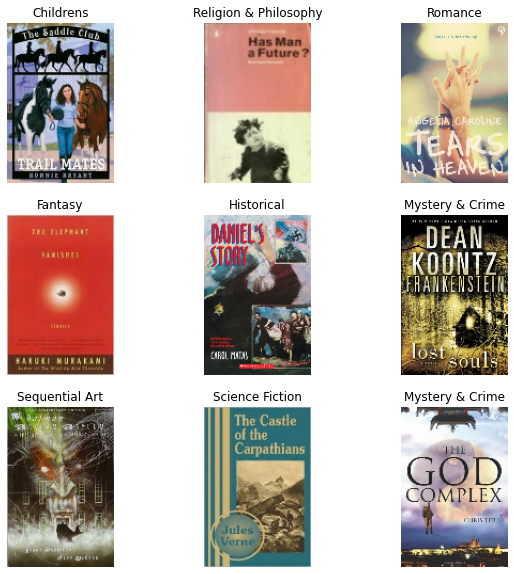

In [195]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Classes

In [131]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
num_classes=13

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3,strides=1, activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
model.compile(
   # optimizer=tf.keras.optimizers.RMSprop(
   # learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=0.001, 
  #  name='RMSprop'
#),
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [132]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
1085/1085 [==============================] - 158s 145ms/step - loss: 2.4580 - accuracy: 0.1700 - val_loss: 2.3459 - val_accuracy: 0.2256
Epoch 2/50
1085/1085 [==============================] - 159s 146ms/step - loss: 2.3783 - accuracy: 0.2031 - val_loss: 2.3230 - val_accuracy: 0.2246
Epoch 3/50
1085/1085 [==============================] - 159s 147ms/step - loss: 2.3536 - accuracy: 0.2087 - val_loss: 2.3029 - val_accuracy: 0.2299
Epoch 4/50
1085/1085 [==============================] - 159s 146ms/step - loss: 2.3365 - accuracy: 0.2141 - val_loss: 2.2913 - val_accuracy: 0.2340
Epoch 5/50
1085/1085 [==============================] - 160s 147ms/step - loss: 2.3192 - accuracy: 0.2223 - val_loss: 2.2734 - val_accuracy: 0.2406
Epoch 6/50
1085/1085 [==============================] - 161s 148ms/step - loss: 2.3040 - accuracy: 0.2249 - val_loss: 2.2588 - val_accuracy: 0.2430
Epoch 7/50
1085/1085 [==============================] - 158s 146ms/step - loss: 2.2885 - accuracy: 0.2280 - val_

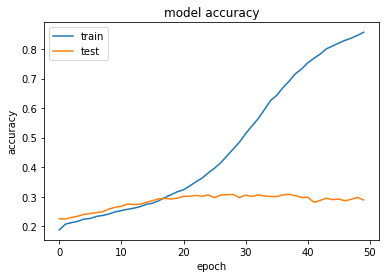

In [140]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [141]:
model.save("model_without_others_03.h5")

In [199]:
import tensorflow_hub as hub
feature_extractor_model ="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_model, input_shape=(150, 100, 3), trainable=False)

In [201]:
from tensorflow.keras import layers
from sklearn.utils import class_weight
model = tf.keras.models.load_model("resnet2_75.h5",custom_objects={'KerasLayer':hub.KerasLayer})

In [202]:
predictions = model.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)

In [203]:
vclasses = list()
vclasses = [[c.numpy() for c in object[1]]for object in val_ds]

In [204]:
validation_classes = np.concatenate(vclasses).ravel()

In [205]:
from sklearn.metrics import classification_report
print(classification_report(validation_classes, predicted_classes, target_names=class_names))

                       precision    recall  f1-score   support

            Biography       0.70      0.58      0.63       389
            Childrens       0.77      0.73      0.75       324
              Fantasy       0.71      0.83      0.76      1737
           Historical       0.69      0.72      0.71       885
               Horror       0.73      0.44      0.55       280
      Mystery & Crime       0.59      0.73      0.65       778
               Poetry       0.78      0.54      0.64       230
   Politics & History       0.63      0.62      0.63       472
Religion & Philosophy       0.62      0.61      0.62       571
              Romance       0.75      0.79      0.77      1284
      Science Fiction       0.86      0.49      0.63       491
       Sequential Art       0.81      0.81      0.81       318
          Young Adult       0.77      0.70      0.73       906

             accuracy                           0.71      8665
            macro avg       0.72      0.66      0.68 

In [28]:
def prediction_score(valid,predictions,cnames=class_names):
    pred = np.argmax(predictions, axis=1)
    pred2 = np.argsort(predictions,axis=1)[:,-2]
    pred3 = np.argsort(predictions,axis=1)[:,-3]
    dict_c = dict(enumerate(cnames))
    scores=[]
    for v,p1,p2,p3 in zip(valid,pred,pred2,pred3):
        score=0
        if v == p1: score=1
        elif v == p2: score =0.75
        elif v == p3: score =0.5
        scores.append([dict_c.get(v),score])
    scores_df = pd.DataFrame(scores,columns=["genre","score"])
    meanscore =np.round(scores_df["score"].mean(),3)
    print("The average score is %s" %meanscore)
    return scores_df.groupby("genre").mean("score")

In [142]:
prediction_score(validation_classes,predictions)

The average score is 0.453


,score
genre,
Biography,0.217525
Childrens,0.467846
Fantasy,0.662452
Historical,0.349532
Horror,0.216038
Mystery & Crime,0.471364
Poetry,0.223810
Politics & History,0.257558
Religion & Philosophy,0.404218


In [143]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
num_classes=13

model2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3,strides=1, activation='relu'),
  layers.Dropout(0.5),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,strides=1,  activation='relu'),
  layers.Dropout(0.5),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,strides=1,  activation='relu'),
  layers.Dropout(0.5),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model2.compile(
  
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [144]:
history2=model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=40
)

Epoch 1/40
1085/1085 [==============================] - 257s 236ms/step - loss: 2.4859 - accuracy: 0.1484 - val_loss: 2.4226 - val_accuracy: 0.2096
Epoch 2/40
1085/1085 [==============================] - 253s 233ms/step - loss: 2.3775 - accuracy: 0.1971 - val_loss: 2.3895 - val_accuracy: 0.2191
Epoch 3/40
1085/1085 [==============================] - 376s 347ms/step - loss: 2.3509 - accuracy: 0.2114 - val_loss: 2.3686 - val_accuracy: 0.2274
Epoch 4/40
1085/1085 [==============================] - 388s 358ms/step - loss: 2.3315 - accuracy: 0.2141 - val_loss: 2.3595 - val_accuracy: 0.2252
Epoch 5/40
1085/1085 [==============================] - 392s 361ms/step - loss: 2.3169 - accuracy: 0.2202 - val_loss: 2.3526 - val_accuracy: 0.2253
Epoch 6/40
1085/1085 [==============================] - 389s 359ms/step - loss: 2.3048 - accuracy: 0.2269 - val_loss: 2.3562 - val_accuracy: 0.2308
Epoch 7/40
1085/1085 [==============================] - 393s 363ms/step - loss: 2.2915 - accuracy: 0.2278 - val_

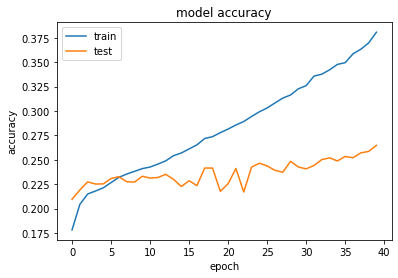

In [145]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [146]:
model2.save("cnndrop.h5")
history22=model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=40
)

Epoch 1/40
1085/1085 [==============================] - 238s 219ms/step - loss: 1.8341 - accuracy: 0.3823 - val_loss: 2.1948 - val_accuracy: 0.2594
Epoch 2/40
1085/1085 [==============================] - 244s 225ms/step - loss: 1.8229 - accuracy: 0.3862 - val_loss: 2.1913 - val_accuracy: 0.2570
Epoch 3/40
1085/1085 [==============================] - 254s 234ms/step - loss: 1.7967 - accuracy: 0.3963 - val_loss: 2.2021 - val_accuracy: 0.2572
Epoch 4/40
1085/1085 [==============================] - 256s 236ms/step - loss: 1.7792 - accuracy: 0.4022 - val_loss: 2.2218 - val_accuracy: 0.2487
Epoch 5/40
1085/1085 [==============================] - 256s 236ms/step - loss: 1.7525 - accuracy: 0.4112 - val_loss: 2.2236 - val_accuracy: 0.2486
Epoch 6/40
1085/1085 [==============================] - 260s 240ms/step - loss: 1.7320 - accuracy: 0.4186 - val_loss: 2.1690 - val_accuracy: 0.2687
Epoch 7/40
1085/1085 [==============================] - 256s 236ms/step - loss: 1.7153 - accuracy: 0.4255 - val_

Non normalised samples with transfer learning 

In [148]:
import tensorflow_hub as hub
feature_extractor_model ="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_model, input_shape=(150, 100, 3), trainable=False)

In [149]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
num_classes=13

model_resnet = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  feature_extractor_layer,
  layers.Dense(256, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [150]:
history_resnet=model_resnet.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
1085/1085 [==============================] - 585s 534ms/step - loss: 2.3488 - accuracy: 0.2290 - val_loss: 2.0306 - val_accuracy: 0.3301
Epoch 2/15
1085/1085 [==============================] - 547s 504ms/step - loss: 1.9888 - accuracy: 0.3382 - val_loss: 1.9838 - val_accuracy: 0.3464
Epoch 3/15
1085/1085 [==============================] - 521s 481ms/step - loss: 1.8794 - accuracy: 0.3779 - val_loss: 1.9698 - val_accuracy: 0.3517
Epoch 4/15
1085/1085 [==============================] - 514s 474ms/step - loss: 1.7924 - accuracy: 0.4076 - val_loss: 1.9698 - val_accuracy: 0.3532
Epoch 5/15
1085/1085 [==============================] - 594s 548ms/step - loss: 1.7135 - accuracy: 0.4389 - val_loss: 1.9797 - val_accuracy: 0.3526
Epoch 6/15
1085/1085 [==============================] - 525s 484ms/step - loss: 1.6367 - accuracy: 0.4655 - val_loss: 1.9981 - val_accuracy: 0.3519
Epoch 7/15
1085/1085 [==============================] - 540s 498ms/step - loss: 1.5605 - accuracy: 0.4926 - val_

VGG16 model

In [158]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

In [154]:
modelVGG = VGG16(include_top=False, input_shape=(150, 100, 3),weights="imagenet",classes=13)

58892288/58889256 [==============================] - 10s 0us/step


In [155]:
for layer in modelVGG.layers:
   layer.trainable = False


In [159]:

x=Flatten()(modelVGG.output)
prediction=Dense(13,activation='softmax')(x)
model_v=Model(inputs=modelVGG.input,outputs=prediction)

In [163]:
model_VGG = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
 model_v
])

In [164]:
model_VGG.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [167]:
history_VGG=model_VGG.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
1085/1085 [==============================] - 1072s 988ms/step - loss: 2.1268 - accuracy: 0.2899 - val_loss: 2.0557 - val_accuracy: 0.3187
Epoch 2/10
1085/1085 [==============================] - 1049s 967ms/step - loss: 2.0135 - accuracy: 0.3308 - val_loss: 2.0221 - val_accuracy: 0.3319
Epoch 3/10
1085/1085 [==============================] - 1066s 983ms/step - loss: 1.9609 - accuracy: 0.3486 - val_loss: 2.0068 - val_accuracy: 0.3378
Epoch 4/10
1085/1085 [==============================] - 1043s 961ms/step - loss: 1.9223 - accuracy: 0.3619 - val_loss: 1.9982 - val_accuracy: 0.3392
Epoch 5/10
1085/1085 [==============================] - 1043s 962ms/step - loss: 1.8912 - accuracy: 0.3713 - val_loss: 1.9931 - val_accuracy: 0.3414
Epoch 6/10
1085/1085 [==============================] - 1042s 961ms/step - loss: 1.8650 - accuracy: 0.3806 - val_loss: 1.9901 - val_accuracy: 0.3416
Epoch 7/10
1085/1085 [==============================] - 1034s 953ms/step - loss: 1.8422 - accuracy: 0.3883

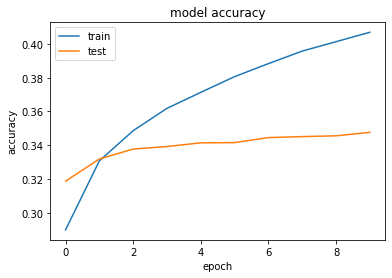

In [168]:
plt.plot(history_VGG.history['accuracy'])
plt.plot(history_VGG.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [169]:
predictions = model_VGG.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)


In [170]:
vclasses = list()
vclasses = [[c.numpy() for c in object[1]]for object in val_ds]
validation_classes = np.concatenate(vclasses).ravel()

In [171]:
from sklearn.metrics import classification_report
print(classification_report(validation_classes, predicted_classes, target_names=class_names))

                       precision    recall  f1-score   support

            Biography       0.23      0.07      0.11       408
            Childrens       0.36      0.35      0.36       311
              Fantasy       0.38      0.69      0.49      1819
           Historical       0.26      0.25      0.25       854
               Horror       0.47      0.03      0.05       265
      Mystery & Crime       0.31      0.40      0.35       777
               Poetry       0.33      0.03      0.06       210
   Politics & History       0.40      0.12      0.18       430
Religion & Philosophy       0.22      0.36      0.27       569
              Romance       0.42      0.45      0.43      1296
      Science Fiction       0.27      0.07      0.11       493
       Sequential Art       0.58      0.41      0.48       332
          Young Adult       0.32      0.07      0.12       914

             accuracy                           0.35      8678
            macro avg       0.35      0.25      0.25 

In [177]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
num_classes=13

x=Flatten()(modelVGG.output)
outs=Dense(256,activation='relu')(x)
model_v2=Model(inputs=modelVGG.input,outputs=prediction)

model_VGG2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  model_v2,
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model_VGG2.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.005,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [178]:
history_VGG2=model_VGG2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
1085/1085 [==============================] - 1106s 1s/step - loss: 2.4130 - accuracy: 0.2142 - val_loss: 2.2174 - val_accuracy: 0.2670
Epoch 2/10
1085/1085 [==============================] - 1046s 964ms/step - loss: 2.2389 - accuracy: 0.2553 - val_loss: 2.1629 - val_accuracy: 0.2815
Epoch 3/10
1085/1085 [==============================] - 1050s 968ms/step - loss: 2.2203 - accuracy: 0.2597 - val_loss: 2.1411 - val_accuracy: 0.2892
Epoch 4/10
1085/1085 [==============================] - 1051s 969ms/step - loss: 2.1985 - accuracy: 0.2695 - val_loss: 2.1494 - val_accuracy: 0.2847
Epoch 5/10
1085/1085 [==============================] - 1063s 980ms/step - loss: 2.2006 - accuracy: 0.2652 - val_loss: 2.1156 - val_accuracy: 0.2976
Epoch 6/10
 230/1085 [=====>........................] - ETA: 13:39 - loss: 2.1653 - accuracy: 0.2774

KeyboardInterrupt: 